In [1]:
%matplotlib inline

In [12]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
from ipywidgets import interact
from tensorflow.examples.tutorials.mnist import input_data

In [10]:
data = mnist.input_data.read_data_sets('./../../data/images/mnist/', one_hot=True)

Extracting ./../../data/images/mnist/train-images-idx3-ubyte.gz
Extracting ./../../data/images/mnist/train-labels-idx1-ubyte.gz
Extracting ./../../data/images/mnist/t10k-images-idx3-ubyte.gz
Extracting ./../../data/images/mnist/t10k-labels-idx1-ubyte.gz


In [76]:
TRAIN = 55000
TEST = 10000
IMG = 64

8: [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


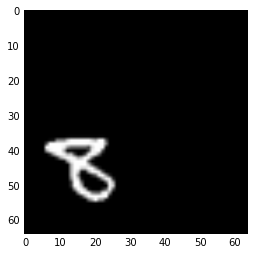

In [232]:
def embed_img(digit):
    # Place image in random position
    img = np.zeros((IMG, IMG), dtype=np.float32)
    i, j = np.random.randint(IMG-28), np.random.randint(IMG-28)
    img[i:i+28,j:j+28] = digit
    
    return img

def random_pair():
    idx = np.random.randint(TRAIN)
    digit = data.train.images[idx].reshape((28,28))
    label = data.train.labels[idx].astype(np.float32)
    
    # Place image in random position
    img = embed_img(digit)
    
    return img, label

def random_test_pair():
    idx = np.random.randint(TEST)
    digit = data.test.images[idx].reshape((28,28))
    label = data.test.labels[idx].astype(np.float32)
    
    # Place image in random position
    img = np.zeros((IMG, IMG), dtype=np.float32)
    i, j = np.random.randint(IMG-28), np.random.randint(IMG-28)
    img[i:i+28,j:j+28] = digit
    
    return img, label

def random_batch(batch):
    batch_imgs = []
    batch_labels = []
    for i in range(batch):
        img, label = random_pair()
        img = img.reshape(IMG ** 2)
        label = label.reshape(10)
        batch_imgs.append(img)
        batch_labels.append(label)
    return np.array(batch_imgs), np.array(batch_labels)
    
img, label = random_pair()

print('{}: {}'.format(np.argmax(label), label))
f = plt.imshow(img, cmap='gray')

In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

x = tf.placeholder(tf.float32, (None, IMG ** 2))
y_ = tf.placeholder(tf.float32, (None, 10))

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, (-1, IMG, IMG, 1))

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


# Fully connected layer

W_fc1 = weight_variable([32 * 32 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 32 * 32 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))

train = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
if 'session' in globals():
    session.close()
    
session = tf.InteractiveSession()
session.run(tf.initialize_all_variables())

In [39]:
for i in range(20000):
    batch_i, batch_l = random_batch(50)
    
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch_i, y_: batch_l, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        
    train.run(feed_dict={x: batch_i, y_: batch_l, keep_prob: 0.5})

step 0, training accuracy 0.3
step 100, training accuracy 0.28
step 200, training accuracy 0.24
step 300, training accuracy 0.3
step 400, training accuracy 0.44
step 500, training accuracy 0.22
step 600, training accuracy 0.28
step 700, training accuracy 0.36
step 800, training accuracy 0.5
step 900, training accuracy 0.4
step 1000, training accuracy 0.38
step 1100, training accuracy 0.46
step 1200, training accuracy 0.5
step 1300, training accuracy 0.54
step 1400, training accuracy 0.6
step 1500, training accuracy 0.72
step 1600, training accuracy 0.64
step 1700, training accuracy 0.52
step 1800, training accuracy 0.72
step 1900, training accuracy 0.64
step 2000, training accuracy 0.78
step 2100, training accuracy 0.82
step 2200, training accuracy 0.84
step 2300, training accuracy 0.78
step 2400, training accuracy 0.86
step 2500, training accuracy 0.84
step 2600, training accuracy 0.7
step 2700, training accuracy 0.86
step 2800, training accuracy 0.74
step 2900, training accuracy 0.8


In [41]:
saver = tf.train.Saver()
saver.save(session, './cnn_translational_inv.ckpt')

'./cnn_translational_inv.ckpt'

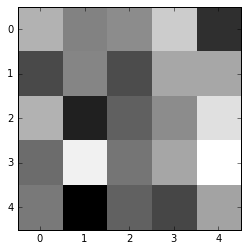

In [91]:
def vis_wc1(i):
    plt.imshow(W_conv2.eval()[:,:,0,i], interpolation='nearest', cmap=plt.cm.gray)
    
interact(vis_wc1, i=(0,31,1))

label: 6 y_conv: 6


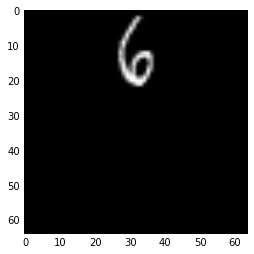

In [296]:
img, label = random_test_pair()

out = y_conv.eval(feed_dict={x: [img.reshape(IMG**2)], keep_prob: 1.0})

print('label: {} y_conv: {}'.format(np.argmax(label), np.argmax(out)))
f = plt.imshow(img, cmap='gray')

In [317]:
# Randomly translate each image in the test data and get accuracy

test_batch = []
test_labels = []
for i in range(2000):
    digit = data.test.images[i].reshape(28, 28)
    
    img = embed_img(digit).reshape(IMG**2)
    test_batch.append(img)
    test_labels.append(data.test.labels[i])


    
print("test accuracy %g"%accuracy.eval(feed_dict={x: test_batch, y_: test_labels, keep_prob: 1.0}))

test accuracy 0.9725


(5, 5, 1, 32)


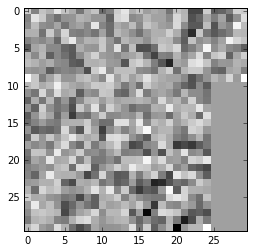

In [340]:
# Visualize all kernels at a certain level

def visualize_W(W):
    print(W.shape)
    side = int(np.ceil(W.shape[0] * np.sqrt(W.shape[3]))) + 1
    img = np.zeros((side, side))
    k = W.shape[0]
    
    io, jo = 0, 0
    for i in range(W.shape[3]):
        img[io:io+k,jo:jo+k] = W[:,:,0,i]
        io += k
        if io > img.shape[0]-k:
            io = 0
            jo += k
            
    plt.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
    
visualize_W(W_conv1.eval())